In [1]:
import pickle
from matplotlib import pyplot 

In [2]:
hist = pickle.load(open( 'history.pkl' , "rb" ))

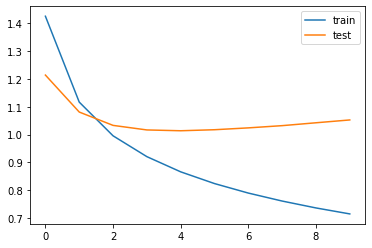

In [3]:

pyplot.plot(hist['loss'], label='train') 
pyplot.plot(hist['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [4]:
import numpy as np
import pandas as pd 
import pickle
from time import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
#cleanfilename = 'cleandatamini.pkl'
cleanfilename = 'cleandata.pkl'
modelfilename = 'model.json'
weightsfilename = 'model.h5'
historyfilename = 'history.pkl'


# In[2]:


print('Loading training data.')


# In[3]:


clean_data = pickle.load( open( cleanfilename , "rb" ) )


# In[4]:


print('Training data loaded. Shape is', clean_data.shape)


# In[27]:


print('Starting to build the embedding index.')


# In[28]:


embeddings_index = {}
f = open('data/glove/glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


# In[29]:


print('Built embeddings index. Found %s word vectors.' % len(embeddings_index))


# In[30]:


def doc2seq(texts, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):
    tokenizer = Tokenizer(filters='"#$%&()*+-/<=>@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    index_word = tokenizer.index_word
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')
    
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return data, embedding_matrix, word_index, index_word


# In[31]:


print('Building text')


# In[32]:


MAX_TEXT_LENGTH = 100
EMBEDDING_DIM = 300
data = clean_data.text

x_data, encoder_emb, x_word_index, x_index_word = doc2seq(data, MAX_TEXT_LENGTH, EMBEDDING_DIM)


# In[33]:


print('Text built. Lengths of x_data, encoder_emb, x_word_index, x_index_word are', 
      list(map(lambda a:len(a), [x_data, encoder_emb, x_word_index, x_index_word ])))


# In[34]:


print('Building headlines ')


# In[35]:


MAX_HEADLINE_LENGTH = 30
EMBEDDING_DIM = 300
data = clean_data.headline

y_data, decoder_emb, y_word_index, y_index_word = doc2seq(data, MAX_HEADLINE_LENGTH, EMBEDDING_DIM)


# In[36]:


print('Headlines built. Lengths of y_data, decoder_emb, y_word_index, y_index_word are', 
      list(map(lambda a:len(a), [y_data, decoder_emb, y_word_index, y_index_word])))


# In[37]:


x_train, x_test_temp, y_train, y_test_temp = train_test_split(x_data, y_data, 
                                                            test_size=0.3, random_state=0) 


# In[38]:


x_dev, x_test, y_dev, y_test = train_test_split(x_test_temp, y_test_temp, 
                                                            test_size=0.33, random_state=0) 


# In[39]:


print('Test Train Dev split done. Length of x_train, y_train,x_dev, y_dev, x_test, y_test are', 
     list(map(len, [x_train, y_train,x_dev, y_dev, x_test, y_test])))


Loading training data.
Training data loaded. Shape is (1387290, 2)
Starting to build the embedding index.
Built embeddings index. Found 400000 word vectors.
Building text
Found 212813 unique tokens.
Text built. Lengths of x_data, encoder_emb, x_word_index, x_index_word are [1387290, 212814, 212813, 212813]
Building headlines 
Found 78682 unique tokens.
Headlines built. Lengths of y_data, decoder_emb, y_word_index, y_index_word are [1387290, 78683, 78682, 78682]
Test Train Dev split done. Length of x_train, y_train,x_dev, y_dev, x_test, y_test are [971103, 971103, 278845, 278845, 137342, 137342]


In [5]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Embedding
from tensorflow.keras.models import Model
from attention_keras.layers.attention import AttentionLayer

In [6]:
MAX_TEXT_LENGTH = 100
MAX_HEADLINE_LENGTH = 30
EMBEDDING_DIM = 300
hidden_units = 600

In [7]:
def create_model():
    enc_embedding_layer = Embedding(len(x_word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[encoder_emb],
                                input_length=MAX_TEXT_LENGTH,
                                trainable=False,
                                name='EncoderEmbeddingLayer')


    dec_embedding_layer = Embedding(len(y_word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[decoder_emb],
                                input_length=MAX_HEADLINE_LENGTH,
                                trainable=False,
                                name='DecoderEmbeddingLayer')


    # Encoder 

    # Encoder input 
    # 2D (sequence_length, None), where sequence length is the MAX_LEN unified by padding in preprocessing
    encoder_inputs = Input(shape=(MAX_TEXT_LENGTH,), name="EncoderInput") 
    enc_emb = enc_embedding_layer(encoder_inputs) 


    #LSTM 1 
    encoder_lstm1 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM1') 
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

    #LSTM 2 
    encoder_lstm2 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM2') 
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

    #LSTM 3 
    encoder_lstm3=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM3') 
    encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2) 

    #LSTM 4 
    encoder_lstm4=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM4') 
    encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3) 

    # Decoder 

    decoder_inputs = Input(shape=(None,), name = 'DecoderInput') 
    #dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
    dec_emb = dec_embedding_layer(decoder_inputs) 

    #LSTM using encoder_states as initial state
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='DecLSTM1') 
    decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

    #Attention Layer
    attn_layer = AttentionLayer(name='attention_layer') 
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

    # Concat attention output and decoder LSTM output 
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    #Dense layer
    decoder_dense = TimeDistributed(Dense(len(y_word_index)+1, activation='softmax')) 
    decoder_outputs = decoder_dense(decoder_concat_input) 

    return Model([encoder_inputs, decoder_inputs], decoder_outputs)




In [8]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    parallel_model = create_model() 
    parallel_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

parallel_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
EncoderEmbeddingLayer (Embeddin (None, 100, 300)     63844200    EncoderInput[0][0]               
__________________________________________________________________________________________________
EncLSTM1 (LSTM)                 [(None, 100, 600), ( 2162400     EncoderEmbeddingLayer[0][0]      
__________________________________________________________________________________________________
EncLSTM2 (LSTM)                 [(None, 100, 600), ( 2882400     EncLSTM1[0][0]                   
______________________________________________________________________________________________

In [9]:
parallel_model.load_weights("model_fd_111519_300units_punct.h5")
print("Loaded model from disk")

Loaded model from disk


In [11]:
encoder_inputs = parallel_model.input[0]
encoder_model = Model(inputs = encoder_inputs, outputs = parallel_model.get_layer('EncLSTM4').output)

decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_hidden_state_input = Input(shape=(MAX_TEXT_LENGTH,hidden_units))

# Get the embeddings of the decoder sequence
dec_emb2= parallel_model.get_layer('DecoderEmbeddingLayer')(parallel_model.input[1])

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = parallel_model.get_layer('DecLSTM1')(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = parallel_model.get_layer('attention_layer')([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = parallel_model.layers[-1](decoder_inf_concat) #This is the time distributed layer

# Final decoder model
decoder_model = Model(
[parallel_model.input[1]] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [12]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0 ):
            newString=newString+y_index_word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+x_index_word[i]+' '
    return newString

In [13]:
def get_top_beam_search_sentences(input_seq, beam=3):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    top_sentences = {}
    
    def top_tokens(last_token, out, h, c):
        output_tokens, h_new, c_new = decoder_model.predict([[last_token]] + [out, h, c])
        top_token_indexes = np.argsort(output_tokens[0, -1, :])[-beam:]
        top_probabilities = output_tokens[0,-1, top_token_indexes]
        return top_token_indexes, top_probabilities, h_new, c_new
        
    #first set of tokens when feeding encoder states and 0 as the first token to the decoder.
    first_tokens, first_probabilities, h, c = top_tokens(0, e_out, e_h, e_c)
    for first_token, first_probability in zip(first_tokens, first_probabilities):
        #initialize top sentences, their corresponding probabilities and states
        top_sentences[y_index_word.get(first_token, '')] = (first_probability, h, c)
    
    
    #loop to iterate over next tokens
    len = 1
    while len < MAX_HEADLINE_LENGTH:
        candidate_sentences = {}
        for sentence, (probability, h, c) in top_sentences.items():
            last_word = sentence.split()[-1] #pick the last word in the sentence as next word
            if(last_word != '.'):
                token = y_word_index.get(last_word, 0) 
                next_tokens, next_probabilities, h_next, c_next = top_tokens(token, e_out, h, c)
                for next_token, next_probability in zip(next_tokens, next_probabilities):
                    new_sentence = sentence.strip() + ' ' + y_index_word.get(next_token, '')
                    candidate_sentences[new_sentence.strip()] = (probability * next_probability, h_next, c_next)
            else:
                candidate_sentences[sentence] = (probability, h, c)

        #print('Candidate sentences')
        #print(candidate_sentences.keys())
        
        #remove low probability candidates
        low_probability_candidates = sorted(candidate_sentences, key=lambda k: candidate_sentences.get(k)[0])[:-beam]
        for low_probability_candidate in low_probability_candidates:
            candidate_sentences.pop(low_probability_candidate)
        
        #Now all candidates left have highest probabilities.
        top_sentences = candidate_sentences
        len = len + 1
        #print('Sentences at the bottom of the loop')
        #print(top_sentences.keys())
        

    return top_sentences

def decode_sequence(input_seq, beam=3):
    top_sentences_obj = get_top_beam_search_sentences(input_seq.reshape(1,-1), beam)
    l = [(sen, prob) for sen, (prob, _, _) in top_sentences_obj.items()]
    return sorted(l, key = lambda x:-x[1])[0][0]

In [14]:
decode_sequence(x_test[3456])

'eat probiotics .'

In [46]:
############
##### helpful functions to help with formatting when printing: 
############
def printmd(string):
    display(Markdown(string)) #just a pretty print 

############
##### function for BLEU 
#############

from nltk.translate.bleu_score import sentence_bleu
# reference: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

def calc_indiv_BLEU(id_text, text_df, headline_df): 
    # This function will take the following as inputs: 
    # id_text: the index you are interested in 
    # gen_text_df: the sequences that hold the full text 
    # headline_df: the sequences that hold the headline text 
    
    # -- Step 1: generate the decoded sequence from a given sample of text
    gen_output = decode_sequence(text_df[id_text].reshape(1,-1))
    split_output = gen_output.split(" ")
    candidate = [item for item in split_output if (item!="." and item!="")] #get rid of empty spaces and periods 
    # -- Step 2: generate the true headline summary from our labelled headline text
    gen_ref = seq2summary(headline_df[id_text])
    split_ref = gen_ref.split(" ")
    #get rid of empty spaces and periods (there shouldn't be any as we already cleaned the headline, but just in case)
    reference = [item for item in split_ref if (item!="." and item!="")] 
    # -- Step 3: calculate BLEU 
    score = sentence_bleu(gen_ref, gen_output, weights=(1, 0, 0, 0))
    # we can alternate weights for cumulative scores afterwards 
    # For now, BLEU is based on unigram counts 
    return(score)

###############
##### function for rouge 
############### 
# PULL METRICS.PY FILE!! 
from metrics import rouge_n_sentence_level
# metrics.py is taken from https://github.com/neural-dialogue-metrics/rouge

# Other useful links to keep in mind: 
# https://stackoverflow.com/questions/38045290/text-summarization-evaluation-bleu-vs-rouge

def calc_indiv_rouge(id_text, text_df, headline_df, rouge_n): 
    # This function will take the following as inputs: 
    # id_text: the index you are interested in 
    # gen_text_df: the sequences that hold the full text 
    # headline_df: the sequences that hold the headline text 
    
    # -- Step 1: generate the decoded sequence from a given sample of text
    gen_output = decode_sequence(text_df[id_text].reshape(1,-1))
    split_output = gen_output.split(" ")
    candidate = [item for item in split_output if (item!="." and item!="")] #get rid of empty spaces and periods 
    # -- Step 2: generate the true headline summary from our labelled headline text
    gen_ref = seq2summary(headline_df[id_text])
    split_ref = gen_ref.split(" ")
    #get rid of empty spaces and periods (there shouldn't be any as we already cleaned the headline, but just in case)
    reference = [item for item in split_ref if (item!="." and item!="")] 
    # -- Step 3: calculate rouge
    recall, precision, rouge = rouge_n_sentence_level(candidate, reference, rouge_n)
    # rouge is actually an f-score of the recall and precision 
    return(recall, precision, rouge)

In [47]:
#############
# Evaluation print-out example 
############# 
from IPython.display import Markdown, display

In [ ]:
for i in range(10,15):
    printmd("**Generated summary:**"+decode_sequence(x_train[i].reshape(1,-1)))
    printmd("**Original summary:**"+seq2summary(y_train[i]))
    printmd("**Text:**"+seq2text(x_train[i]))
    printmd("**BLEU score(Unigram):** "+str(calc_indiv_BLEU(i, x_train, y_train)))
    rouge_n = 1 #this can be edited pending how we decide to evaluate ROUGE 
    printmd("**ROUGE-**"+str(rouge_n)+"**-Recall:** "+str(calc_indiv_rouge(i,x_train,y_train,rouge_n)[0]))
    printmd("**ROUGE-**"+str(rouge_n)+"**-Precision:** "+str(calc_indiv_rouge(i,x_train,y_train,rouge_n)[1]))
    printmd("**ROUGE-**"+str(rouge_n)+"**-Fscore:** "+str(calc_indiv_rouge(i,x_train,y_train,rouge_n)[2]))
    print('_________________________________________________________________')

In [50]:
bleu_total= 0
for i in range(len(x_train[:10])):
    bleu_total += calc_indiv_BLEU(i, x_train, y_train)

In [51]:
BLEU = bleu_total/len(x_train[:10])

In [52]:
print(BLEU)

0.1393015078330715


In [59]:
rouge_recall_total, rouge_precision_total, rouge_f_total= 0,0,0
for i in range(len(x_test[:20])):
    rouge_recall, rouge_precision, rouge_f = calc_indiv_rouge(i, x_test, y_test,1)
    rouge_recall_total += rouge_recall
    rouge_precision_total += rouge_precision
    rouge_f_total += rouge_f

In [61]:
rouge_recall_total/20

0.17671987734487735

In [62]:
rouge_precision_total/20

0.23347222222222222

In [63]:
rouge_f_total/20

0.18876909038673745

In [89]:
res = decode_sequence_beam(x_test[199].reshape(1,-1), 15)

In [90]:
l = [(sen, prob) for sen, (prob, _, _) in res.items()]

In [91]:
sorted(l, key = lambda x:-x[1])

[('choose the ingredients that you need for the recipe .', 0.29022956),
 ('choose the ingredients you need for the recipe .', 0.012860966),
 ('choose the ingredients that you need .', 0.012043308),
 ('choose the ingredients that you need for your recipe .', 0.011410826),
 ('choose the ingredients that need for the recipe .', 0.007939939),
 ('choose the recipe that you need for the recipe .', 0.0067652366),
 ('choose your ingredients that you need for the recipe .', 0.0055452096),
 ('choose the salmon that you need for the recipe .', 0.005466914),
 ('choose the cheese that you need for the recipe .', 0.005388176),
 ('choose your ingredients .', 0.0037132106),
 ('choose the utensil that you need for the recipe .', 0.003289203),
 ('choose the tomato that you need for the recipe .', 0.0030044427),
 ('choose the ingredients that you need for the recipe to be .', 0.0028947894),
 ('choose the ingredients that you need for the recipe to .', 0.0026848372),
 ('choose the correct ingredients that

In [92]:
decode_sequence(x_test[199].reshape(1,-1))

' choose the ingredients that you need for the recipe . . . . . . . . . . . . . . . . . . . .'

In [93]:
seq2summary(y_test[199])

'choose the ingredients that you need for the recipe . '

In [94]:
seq2text(x_test[199])

'press the a button again and start to make the dish . '

In [17]:
for i in range (3456, 3476):
    print('------------Beam Search--------------------------', i)
    print(decode_sequence(x_test[i].reshape(1,-1), 3))
    print('------------Greedy Search------------------------')
    print(decode_sequence(x_test[i].reshape(1,-1), 1))
    print('------------Ground Truth-------------------------')
    print(seq2summary(y_test[i]))
    print('------------Document-----------------------------')    
    print(seq2text(x_test[i]))
    print('=================================================')


------------Beam Search-------------------------- 3456
eat probiotics .
------------Greedy Search------------------------
eat probiotics .
------------Ground Truth-------------------------
eat probiotics and prebiotics . 
------------Document-----------------------------
they can also protect your gut from harmful bacteria that irritates your bowels . since it is hard to gauge how many colony forming units of probiotics cfus are in foods , eat a variety of foods known to contain probiotics and prebiotics . to get probiotics in your diet , eat leafy green vegetables kale , spinach , swiss chard , spinach , beet greens , collard greens , mustard greens , broccoli , cauliflower , and cabbage . to get prebiotics , eat chicory root jerusalem artichoke dandelion greens garlic leeks asparagus wheat bran baked wheat flour bananas 
------------Beam Search-------------------------- 3457
install the fan motor assembly .
------------Greedy Search------------------------
attach the fan motor assemb

click the star icon .
------------Greedy Search------------------------
click the star icon .
------------Ground Truth-------------------------
click on the field next to default web browser . 
------------Document-----------------------------
this should be at the top of the general tab . you can select your preferred web browser from here . 
------------Beam Search-------------------------- 3470
use dialogue .
------------Greedy Search------------------------
use dialogue and dialogue .
------------Ground Truth-------------------------
include stream of consciousness and or dialogue . 
------------Document-----------------------------
when little direct action is taking place , recording the character s thoughts or conversations keeps the reader engaged . when using dialogue , note the speaker’s tone or inflection , any pauses or tics , or unusual words choices . do they gesture while they speak or use meaningful body language are they saying what they really think or hiding their tr